<a href="https://colab.research.google.com/github/jaipandotco2525/python/blob/master/Cheminfo_rdkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chem_info Project Based Learning 2019/09/21
# chem_project team2


### RDKIt

[RDKit]（https://www.rdkit.org/） は、非常に強力で便利なツールキットですが、Google Colaboratoryにはインストールされていないオープンソースの化学情報学ソフトウェアです。

したがって、最初にrdkitパッケージをインストールする必要があります。 Google Colabはすべてのセッションで初期化される仮想サーバーであるため、すべてのセッションをインストールする必要あり。



In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-01-18 17:53:05--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M  85.1MB/s    in 0.8s    

2020-01-18 17:53:06 (85.1 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c

環境設定

In [0]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages')

すべてのパッケージが適切にインストールされると、次のセルに次のテキストが表示されます。

ドキュメントについては、ドキュメントツリーのChem / index.htmlを参照

In [3]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
# from rdkit import Chem

print(Chem.__doc__)

 A module for molecules and stuff

 see Chem/index.html in the doc tree for documentation




さらにツールをimport

In [0]:
from numpy import vectorize as vec
import scipy as sp
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors,PandasTools


### Tox21 data set
毒物データベース
今回は7534種類の分子から学習データを75%（このうち活性アリが218種類、活性無しが5297種類）
テストデータを25%（活性アリ78種類、活性無しが1761種類）を準備して重複データを削除して機械学習を行った。

Download a datafile `na-ar.sdf` from the link below.

https://drive.google.com/uc?id=1ALUNDgAmpauEa0Oa6-6TOPAG_uDTy0HH&export=download

Download a datafile `washed-nr-er.tsv` from the link below.

https://docs.google.com/uc?id=1N-Qykm94hz8NFPppYgTYcQwiRhqJNimw&export=download

次のセルを実行します。アップロードするファイルを選択するように求められるので、ローカルマシンからダウンロードしたファイルをアップロードします。

In [12]:
from google.colab import files
uploaded = files.upload()

Saving washed-nr-er.tsv to washed-nr-er (1).tsv


次のセルを実行します。アップロードするファイルを選択するように求められるので、ローカルマシンからダウンロードしたファイルをアップロードします。

In [13]:
! ls -la

total 89572
drwxr-xr-x 1 root root     4096 Jan 18 18:09  .
drwxr-xr-x 1 root root     4096 Jan 18 17:51  ..
drwxr-xr-x 1 root root     4096 Jan 13 16:38  .config
-rwxr-xr-x 1 root root 71785000 Oct 25 19:35  Miniconda3-latest-Linux-x86_64.sh
-rw-r--r-- 1 root root  1024000 Jan 18 18:08 'nr-ar (1).sdf'
-rw-r--r-- 1 root root 17862205 Jan 18 18:02  nr-ar.sdf
drwxr-xr-x 1 root root     4096 Jan 13 16:38  sample_data
-rw-r--r-- 1 root root   515648 Jan 18 18:09 'washed-nr-er (1).tsv'
-rw-r--r-- 1 root root   515648 Jan 18 18:09  washed-nr-er.tsv


次に、アップロードされた分子データを読み取ります。

（ファイルの読み取り時のエラーを無視します）

 `na-ar.sdf`は元のデータセットです。

`washed-nr-er.tsv`はキュレーションされたデータセットです。

In [14]:
mols=PandasTools.LoadSDF('nr-ar.sdf',smilesName='SMILES',molColName='Molecule',includeFingerprints=True)


RDKit ERROR: [18:10:01] Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [18:10:01] ERROR: Could not sanitize molecule ending on line 153869
RDKit ERROR: [18:10:01] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [18:10:03] Explicit valence for atom # 3 Cl, 2, is greater than permitted
RDKit ERROR: [18:10:03] ERROR: Could not sanitize molecule ending on line 223779
RDKit WARNING: [18:10:04] Warning: conflicting stereochemistry at atom 9 ignored.
RDKit WARNING: [18:10:04] Warning: conflicting stereochemistry at atom 9 ignored.
RDKit ERROR: [18:10:03] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
RDKit ERROR: [18:10:06] Explicit valence for atom # 1 Cl, 2, is greater than permitted
RDKit ERROR: [18:10:06] ERROR: Could not sanitize molecule ending on line 339188
RDKit WARNING: [18:10:07] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [18:10:06] ERROR: Explicit valence for atom # 1 Cl,

In [0]:
mols_washed = pd.read_csv('washed-nr-er.tsv')


新しいデータを読み込むときは詳細なデータ構造を確認

In [16]:
mols.shape

(9357, 7)

mols_washed.shape

In [17]:
mols.columns

Index(['Formula', 'FW', 'DSSTox_CID', 'Active', 'ID', 'SMILES', 'Molecule'], dtype='object')

`head()` は大きなデータを確認するのに適した方法です



したがって、何らかの機械学習モデルを使用して、分子構造から毒性を「予測」できると便利です。危険な化学物質を避け、新薬の候補を見つけるのに役立ちます。

ただし、分子構造は非常に複雑なので、分子記述子と呼ばれる数値表現に変換します。


,Active,DSSTox_CID,FW,Formula,ID,Molecule,SMILES
0,0,26683,1342.5025 (1282.4505+60.0520),C66H87N17O14,NCGC00167516-01,,CC(=O)O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=...
1,0,26837,419.0430 (382.5820+36.4609),C25H39ClN2O,NCGC00181091-01,,CCCCCCOc1ccc(C(=N)N(CCCC)CCCC)c2ccccc12.Cl

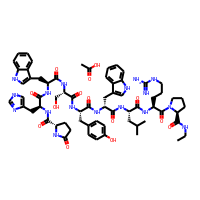
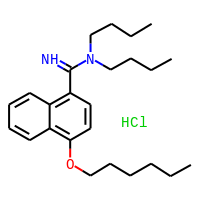

In [21]:
mols[['Active', 'DSSTox_CID', 'FW', 'Formula', 'ID', 'Molecule', 'SMILES']].head(2)

In [22]:
mols['Active'][0:4]

0    0
1    0
2    0
3    0
Name: Active, dtype: object

In [23]:
print("Number of active :  ", list(mols.Active).count('1')) 
print("Number of inactive :  ", list(mols.Active).count('0')) 

Number of active :   380
Number of inactive :   8977


In [24]:
names = [x[0] for x in Descriptors._descList]
print("Number of descriptors intherdkit: ", len(names))
np.array(names)[0:10]


Number of descriptors intherdkit:  200


array(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons'],
      dtype='<U24')

In [25]:
for desc in ['TPSA','MaxPartialCharge','SlogP_VSA1','EState_VSA1','SMR_VSA1','MolLogP','MolMR','BalabanJ','Ipc','HallKierAlpha','Kappa1','Kappa2','Kappa3','RingCount','NumHAcceptors','NumHDonors']:
    exec("mols[desc]=vec(Descriptors.{})(mols['Molecule'])".format(desc))
print("shape of data : {}".format(mols.shape))


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


shape of data : (9357, 23)


In [26]:
print(mols.isnull().any())

Formula             False
FW                  False
DSSTox_CID          False
Active              False
ID                  False
SMILES              False
Molecule            False
TPSA                False
MaxPartialCharge     True
SlogP_VSA1          False
EState_VSA1         False
SMR_VSA1            False
MolLogP             False
MolMR               False
BalabanJ            False
Ipc                 False
HallKierAlpha       False
Kappa1              False
Kappa2              False
Kappa3              False
RingCount           False
NumHAcceptors       False
NumHDonors          False
dtype: bool


分子記述子の一覧（それぞれ環構造の特徴を表しているものや、分子分極率等分子の構成に関わる記述子など様々なものがある。）

In [0]:
mols_desc=mols.drop(["MaxPartialCharge","Ipc","Kappa3", "Active", "DSSTox_CID", "FW", "Formula", "ID", "Molecule", "SMILES"], axis=1)

いくつかの分子特性の分布と相関関係を見てみる

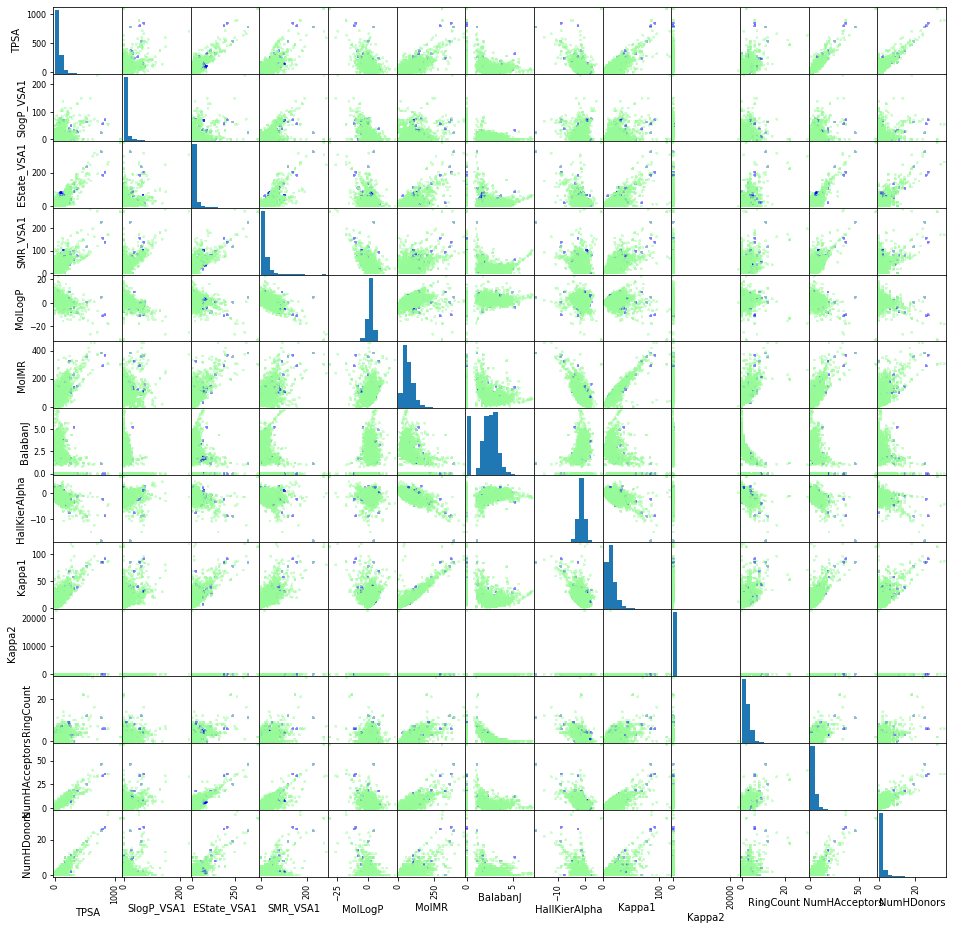

In [29]:
def set_color(L):
  tmp = []
  for l in L:
    if l == '1':
      tmp.append("red")
    else:
      tmp.append("palegreen")
  return tmp

pd.plotting.scatter_matrix(mols_desc,figsize=(16,16), hist_kwds={'bins':15},  
                           marker='+', s=8, alpha=.5, c=set_color(mols.Active))
plt.show()

### Classifier

例として、ランダムフォレストを用いて、分子が有毒かどうかを分類してみる。


検証のために、トレーニングデータとテストデータを分離する。

In [0]:
X_train, X_test, y_train, y_test = train_test_split(mols_desc, mols.Active, train_size=0.75, test_size=0.25)

In [31]:
print("Training Data")
print("Number of   active :  ", list(y_train).count('1'))
print("Number of inactive :  ", list(y_train).count('0'))
print("Test Data")
print("Number of   active :  ", list(y_test).count('1'))
print("Number of inactive :  ", list(y_test).count('0'))

Training Data
Number of   active :   294
Number of inactive :   6723
Test Data
Number of   active :   86
Number of inactive :   2254


### 試した学習手法
•	Random-forest
データセットの様々なサブサンプルにいくつかの決定木分類器を当てはめ、予測精度を向上させて過剰適合を制御するために平均化を使用する手法。

•	Extremely Randomized Trees
Random-Forest は 決定木を作る際に分岐させる位置を網羅的に探索し、基準を決めて最も良い部分を選びますが、この手法では分岐関数をランダムで選択する手法となっております。

•	Gradient Boosting（勾配ブースティング）
決定木を逐次的に増やしていき、１つ前の決定木の誤りを次の決定木が修正するようにして、新たな決定木を順番に生成していく手法。

LightGBM：左右均等に決定木を成⻑させるのではなく、あくまで目的関数を最小にする向きに成⻑させる特徴がある勾配ブースティングの1種の手法

訓練データの特徴量を階級に分けてヒストグラム化することで、意図的に厳密な枝分かれを探さず大規模なデータセットに対して、計算コストを抑えることが可能な手法となっております。


###ここでは、ランダムフォレストで学習させた結果とコードを提示する



In [32]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [35]:
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set:     {:.3f}".format(model.score(X_test , y_test)))
df = pd.DataFrame(model.feature_importances_, index = X_train.columns)
df

Accuracy on training set: 0.995
Accuracy on test set:     0.977


,0
TPSA,0.051757
SlogP_VSA1,0.144705
EState_VSA1,0.069956
SMR_VSA1,0.071256
MolLogP,0.053739
MolMR,0.078440
BalabanJ,0.080226
HallKierAlpha,0.161190
Kappa1,0.073346
Kappa2,0.079867


scikit-learnライブラリには、何百ものツールとアルゴリズムが実装されています。 化学記述子を使用して分子を予測/分類する他のモデルと方法を選択できます。

下のセルは勾配ブースティング回帰木の例を提示



In [34]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.1,max_depth=7,n_estimators=1000, random_state=0)
model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)